# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into the [`deepracer-utils` library](https://github.com/aws-deepracer-community/deepracer-utils).

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:
* AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html
* Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

* AWS DeepRacer Team for initial workbooks created for DeepRacer Workshops at Summits and re:Invent.
* [CodeLikeAMother](https://codelikeamother.uk) for initial rework of the notebook.
* [The AWS DeepRacer Community](http://join.deepracing.io) for feedback and incremental improvements.

# Log Analysis

Let's get to it.

## Installs and setups

If you are using an AWS SageMaker Notebook or Sagemaker Studio Lab to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [189]:
# Make sure you have the required pre-reqs

# import sys

# !{sys.executable} -m pip install --upgrade -r requirements.txt

## Imports

Run the imports block below:

In [190]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import os

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog, \
    S3FileHandler, FSFileHandler

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Login

Login to AWS. There are several ways to log in:
1. On EC2 instance or Sagemaker Notebook with correct IAM execution role assigned.
2. AWS credentials available in `.aws/` through using the `aws configure` command. (DeepRacer-for-Cloud's `dr-start-loganalysis` supports this)
3. Setting the relevant environment variables by uncommenting the below section.

In [191]:
# os.environ["AWS_DEFAULT_REGION"] = "" #<-Add your region
# os.environ["AWS_ACCESS_KEY_ID"] = "" #<-Add your access key
# os.environ["AWS_SECRET_ACCESS_KEY"] = "" #<-Add you secret access key
# os.environ["AWS_SESSION_TOKEN"] = "" #<-Add your session key if you have one

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. The simplest way to read in training data is using the sim-trace files.

For other ways to read in data look at the [configuration examples](https://github.com/aws-deepracer-community/deepracer-utils/blob/master/docs/examples.md).

In [192]:
# PREFIX='model-name'   # Name of the model, without trailing '/'
# BUCKET='bucket'       # Bucket name is default 'bucket' when training locally
# PROFILE=None          # The credentials profile in .aws - 'minio' for local training
# S3_ENDPOINT_URL=None  # Endpoint URL: None for AWS S3, 'http://minio:9000' for local training

In [193]:
# fh = S3FileHandler(bucket=BUCKET, prefix=PREFIX, profile=PROFILE, s3_endpoint_url=S3_ENDPOINT_URL)
# log = DeepRacerLog(filehandler=fh)
# log.load_training_trace()

In [194]:
# # Example / Alternative for logs on file-system
fh = FSFileHandler(model_folder='logs/discrete-1-2-1-training_job_dPkJNvOrQ2S2Brq5l8_XGQ_logs/75c480d4-d884-43aa-941b-1beb46fde56c', robomaker_log_path='logs/discrete-1-2-1-training_job_dPkJNvOrQ2S2Brq5l8_XGQ_logs/75c480d4-d884-43aa-941b-1beb46fde56c/logs/training/training-20240327083644-dPkJNvOrQ2S2Brq5l8_XGQ-robomaker.log')
log = DeepRacerLog(filehandler=fh)
log.load_robomaker_logs()

In [195]:
try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Logs not available")

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '5.0'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.99,
 'e_greedy_value': 1.0,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 100000.0,
 'term_cond_max_episodes': 100000}
-------------
[{'index': 0, 'speed': 1.2, 'steering_angle': -30},
 {'index': 1, 'speed': 1.9, 'steering_angle': -30},
 {'index': 2, 'speed': 1.2, 'steering_angle': -15},
 {'index': 3, 'speed': 2.2, 'steering_angle': -15},
 {'index': 4, 'speed': 3.7, 'steering_angle': 0},
 {'index': 5, 'speed': 2.5, 'steering_angle': 0},
 {'index': 6, 'speed': 1.5, 'steering_angle': 15},
 {'index': 7, 'speed': 2.2, 'steering_angle': 15},
 {'index': 8, 'speed': 1.2, 'steering_angle': 30},
 {'index': 9, 'speed': 1.8, 'steering_angle': 23},
 {'index

In [196]:
df = log.dataframe()

If the code above worked, you will see a list of details printed above: a bit about the agent and the network, a bit about the hyperparameters and some information about the action space. Now let's see what got loaded into the dataframe - the data structure holding your simulation information. the `head()` method prints out a few first lines of the data:

In [197]:
df.head()

,iteration,episode,steps,x,y,yaw,steering_angle,speed,action,reward,done,on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration
0,1,0,1,3.1999,0.6831,0.1831,0.0,3.7,4,0.0000,0,True,0.7915,1,17.71,5.355,prepare,0.0
1,1,0,2,3.1996,0.6831,0.1790,0.0,3.7,4,136.0662,0,True,0.7899,1,17.71,5.423,in_progress,0.0
2,1,0,3,3.2105,0.6831,0.1867,-30.0,1.9,1,62.6368,0,True,0.8512,1,17.71,5.492,in_progress,0.0
3,1,0,4,3.2325,0.6715,-2.3056,23.0,1.8,9,58.0564,0,True,0.9757,1,17.71,5.562,in_progress,0.0
4,1,0,5,3.2657,0.6591,-4.8306,30.0,1.2,8,47.9228,0,True,1.1627,1,17.71,5.623,in_progress,0.0


## Load waypoints for the track you want to run analysis on

The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [198]:
tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_april_open.npy - I don't know
2022_april_open_ccw.npy - I don't know
2022_april_open_cw.npy - I don't know
2022_april_pro.npy - I don't know
2022_april_pro_ccw.npy - I don't know
2022_april_pro_cw.npy - I don't know
2022_august_open.npy - I don't know
2022_august_open_ccw.npy - I don't know
2022_august_open_cw.npy - I don't know
2022_august_pro.npy - I don't know
2022_august_pro_ccw.npy - I don't know
2022_august_pro_cw.npy - I don't know
2022_july_open.npy - I don't know
2022_july_pro.npy - I don't know
2022_july_pro_ccw.npy - I don't know
2022_july_pro_cw.npy - I don't know
2022_june_open.npy - I don't know
2022_june_open_ccw.npy - I don't know
2022_june_open_cw.npy - I don't know
2022_june_pro.npy - I don't know
2022_june_pro_ccw.npy - I don't know
2022_june_pro_cw.npy - I don't know
2022_march_open.npy - I don't know
2022_march_open_ccw.npy - I don't know
2022_march_open_cw.npy - I don't know
2022_march_pro.npy - I don't know
2022_march_pro_ccw.npy - I don't know
2022_march_pr

Now let's load the track:

reinvent_base
Loaded 119 waypoints


<Axes: >

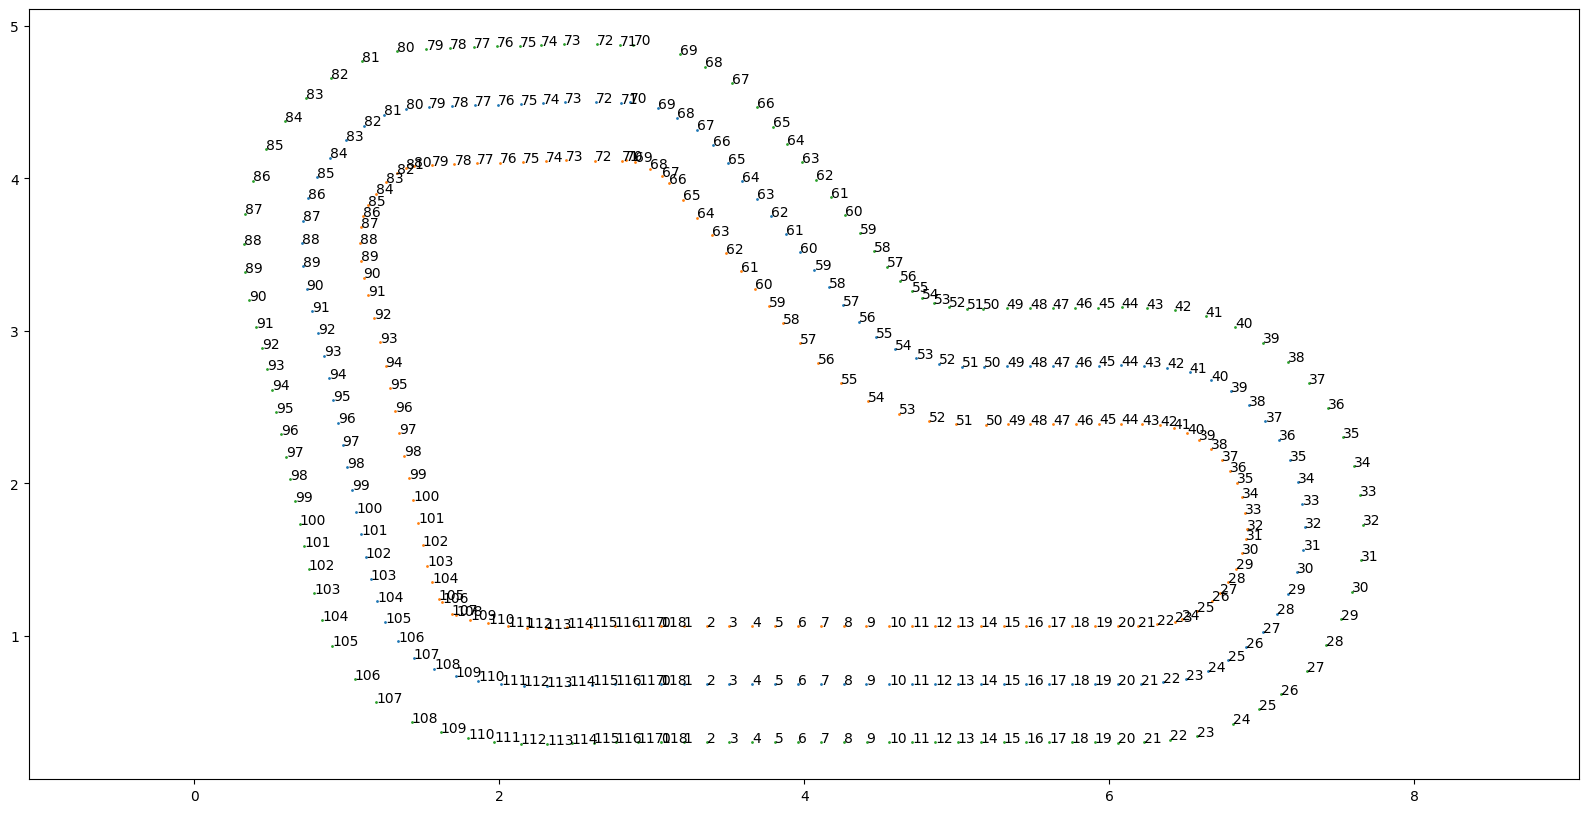

In [199]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reinvent_base"

print(track_name)

track: Track = tu.load_track(track_name)

pu.plot_trackpoints(track)

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).
正如您现在可能已经注意到的那样，训练集被分组为迭代，此笔记本也反映了这一点。同样标志着它的是培训中的检查点。每次迭代后，都会生成一组 ckpt 文档，其中包含训练结果，然后基于该文档构建一个 model.pb 文档，汽车开始新的迭代。查看按迭代分组的数据可能会得出一个结论，即一些更早的检查点将是新训练的更好开始。虽然这在 AWS DeepRacer 控制台中受到限制，但只要有足够的磁盘空间，您就可以沿途保留所有检查点，并将其中一个检查点用作新训练的开始（甚至作为比赛的提交）。

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.
虽然给定迭代中的情节是决策过程和随机猜测的混合体，但每次迭代的平均结果可能显示特定趋势。平均值伴随着标准差，以显示平均值附近的值集中度。

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

您可以在 AWS DeepRacer 控制台中以每集的线或点的形式查看这些值。当奖励上升时，这表明汽车正在学习和改进给定的奖励功能。**这不一定是一件好事。 如果你的奖励功能奖励了损害性能的东西，你的汽车将学会以一种会使结果变得更糟的方式驾驶。

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:
起初，如果取得的进步增加，回报就会增加。在培训的后期可能会发生一些有趣的事情：
* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
奖励可能会在某种程度上持平，这可能意味着汽车不会变得更好。如果你认为你仍然可以从中榨取更好的东西，请查看汽车的进度并考虑更新奖励函数、动作空间、超参数，或者重新开始（从头开始或从以前的某个检查点开始）

* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it

奖励可能会变得摇摆不定，在这里你会看到它是一个锯齿形的点网。它可以是逐渐增长的锯齿形，也可以是大致停滞的。这通常意味着学习率超参数太高，并且汽车开始执行围绕某个局部极端振荡的动作。你可以降低学习率，希望更接近极端。或者如果你不喜欢它，就逃避它

* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

奖励暴跌到接近零并大致持平，我只在搞砸超参数或奖励函数时才有。查看最近的更改并重新开始培训或考虑从头开始

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

标准差表示给定迭代中每集奖励值之间的接近程度。如果您的模型变得相当稳定，并且最差的性能变得更好，则在某些时候，标准差可能会趋于平缓甚至降低。也就是说，更高的速度通常意味着赛道上会有更高的故障风险区域。这可能会使标准差的价值达到更高的值，无论你喜欢与否，你都需要接受它作为争取更好时代的一部分。

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.
我不确定这张图有多大用处。我会担心如果它看起来与奖励图非常相似，这可能表明较慢的圈速将获得更高的奖励。但是下面有一个更好的图表可以发现这一点
#### Progress per Iteration
每次迭代的进度
This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.
这张图通常从低处开始，然后逐渐增长，在某个时候它会变得更平坦。进步的最大值是 100%，因此它不能无限制地增长。它通常显示与奖励和时间图相似的初始行为。当我在训练中改变一个动作时，我通常会看它。在这种情况下，该图表通常会略微下降，然后返回或走高。
#### Total reward per episode
每集总奖励
This graph has been taken from the original notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.
此图取自原始笔记本，可以显示某些行为组的进展。它通常形成一个三角形，有时你可以看到一条清晰的进步线，表明一些新方法首先被教授，然后被完善。
#### Mean completed lap times per iteration
每次迭代的平均完成单圈时间
Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:
一旦我们有一个可以合理地经常完成圈数的模型，我们可能想知道汽车在赛道上的速度有多快。这张图将向你展示这一点。在寻找可以多剃几毫秒的模型时，我经常使用它。也就是说，它必须与最后一个配对：
#### Completion rate per iteration
每次迭代的完成率

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of dividing amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.
它表示迭代中所有剧集中有多少部分是整圈的。该值来自范围 [0， 1]，是迭代中整圈数除以迭代中所有剧集数的结果。我说它必须与前一个配对，因为你不仅需要一个快速的圈速，你还需要一个比赛完成者。

The higher the value, the more stable the model is on a given track.
该值越高，模型在给定轨道上的稳定性越高

new reward not found, using reward as its values
Multiple workers not detected, assuming 1 worker
Number of episodes =  244
Number of iterations =  13


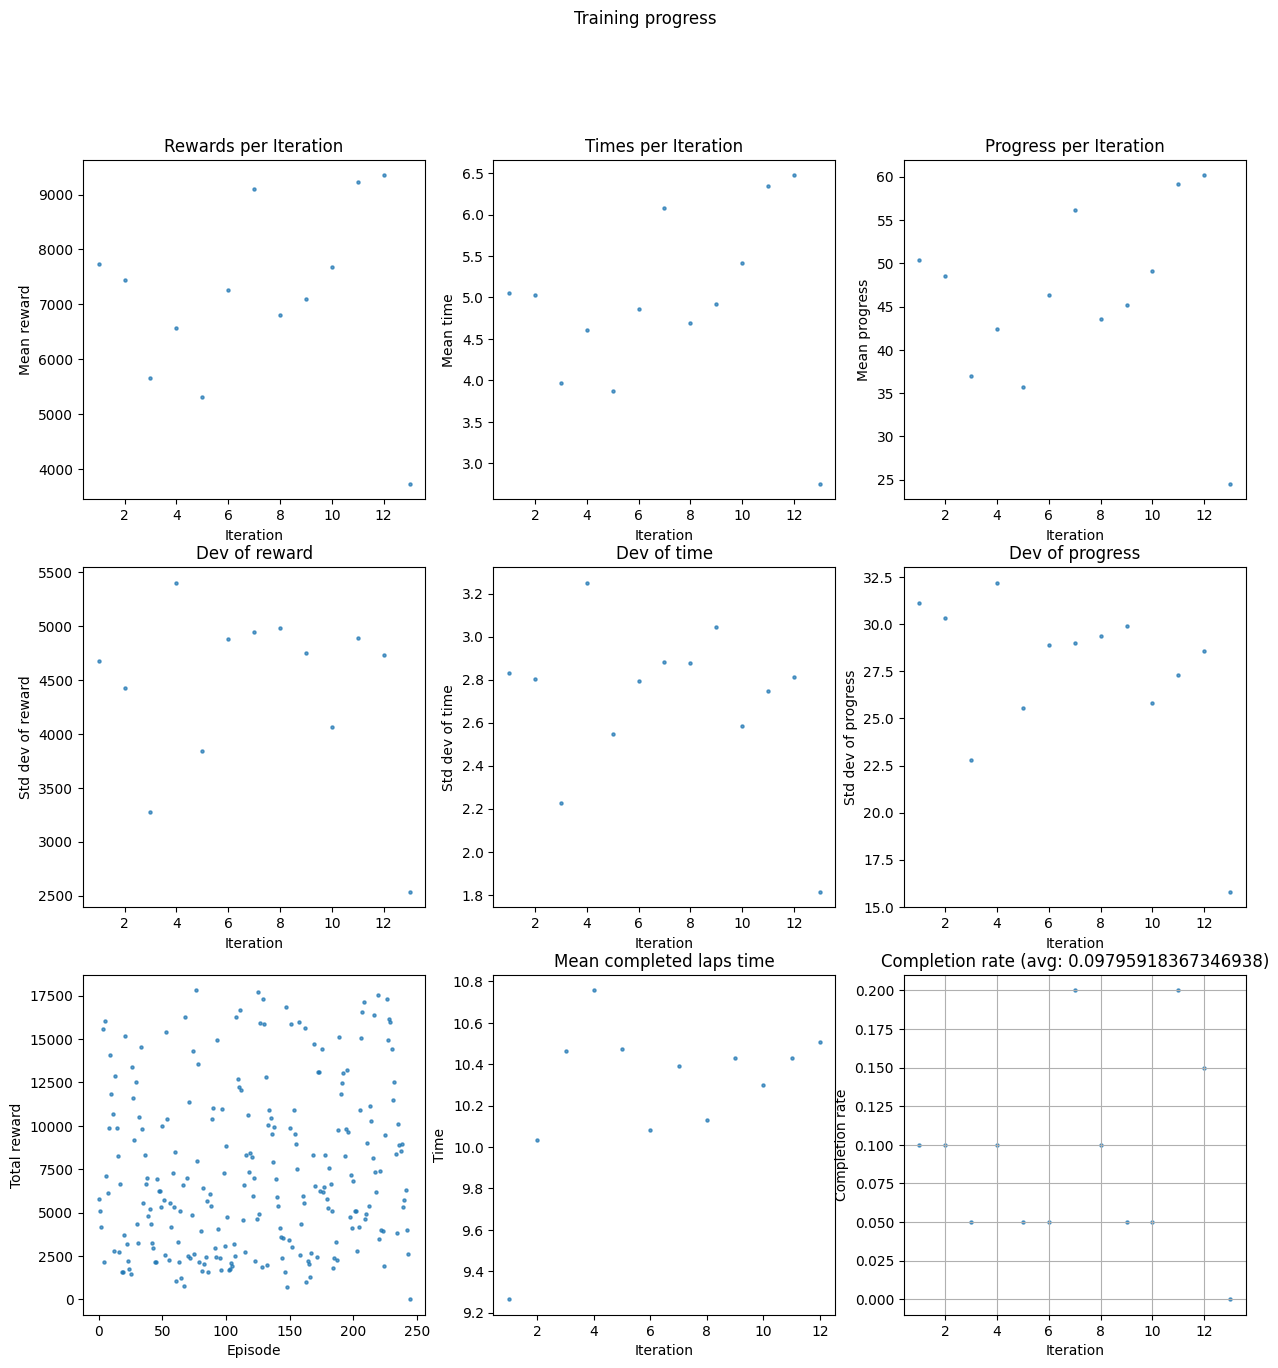

<Figure size 640x480 with 0 Axes>

In [200]:
simulation_agg = au.simulation_agg(df)
try: 
    if df.nunique(axis=0)['worker'] > 1:
        print("Multiple workers have been detected, reloading data with grouping by unique_episode")
        simulation_agg = au.simulation_agg(df, secondgroup="unique_episode")
except:
    print("Multiple workers not detected, assuming 1 worker")

au.analyze_training_progress(simulation_agg, title='Training progress')

### Stats for all laps
所有圈数的统计数据
Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.
以前的图表主要关注与培训进度相关的培训状态。然而，这不会给你很多关于你的奖励函数整体表现如何的信息。

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
在这种情况下，“scatter_aggregates”可能会派上用场。它带有三种类型的图形：
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
进度/步骤/奖励 根据这一集的时间，我发现奖励/时间和new_reward/时间特别有用，可以看到我正在奖励良好的行为，我希望奖励时间分散看起来大致是三角形的
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
所有剧集的时间和进度直方图 进度通常非常方便，可以了解模型的稳定性
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place
进度/time_if_complete/奖励到开始时最接近的航点，这些在训练期间非常有用，因为它们显示了赛道上潜在的问题点。事实证明，如果汽车在其他地方起步，则汽车会从一个无法到达的点开始获得最佳奖励（和性能），或者汽车难以通过赛道的某个部分，这可能是由激进的动作空间或该地点之前的不良行为引起的
Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.
旁注：“time_if_complete”不是很准确，对于接近 100% 进度的剧集，几乎总是比 50% 及以下的剧集看起来更好。

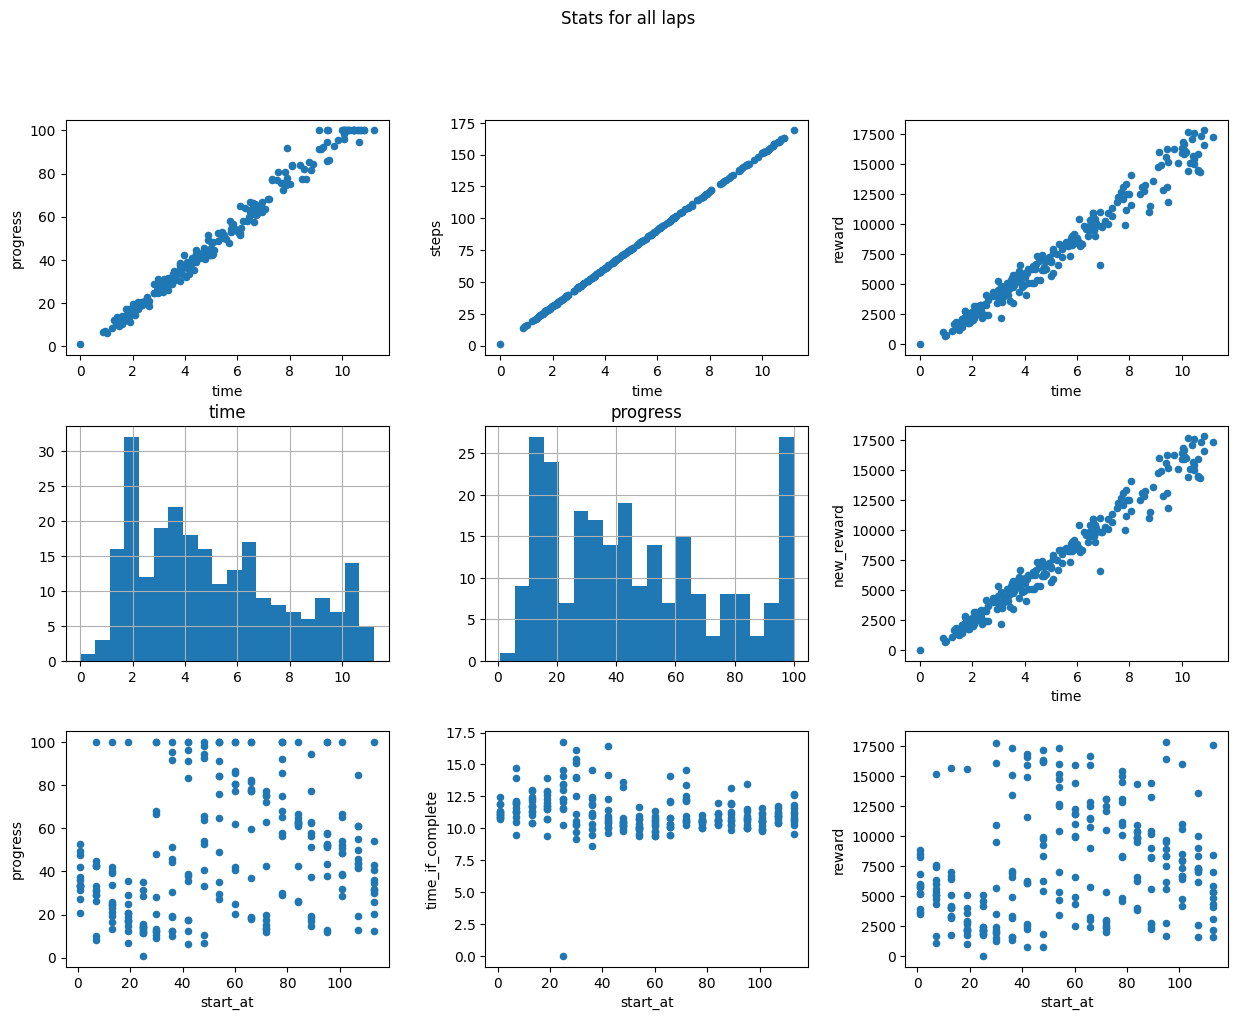

<Figure size 640x480 with 0 Axes>

In [201]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
完整圈数的统计数据
The graphs here are same as above, but now I am interested in other type of information:
这里的图表与上面的图表相同，但现在我对其他类型的信息感兴趣：
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
奖励分散是否显示更短的完成时间更高的奖励？如果我为较慢的圈速提供更高的奖励，这可能表明我正在训练汽车慢速行驶
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
时间直方图是什幺样的？有了足够的样本，直方图就会呈现正态分布图的形状。平均值越低，始终如一地完成快速圈速的机会就越大。尾巴越长，在提交中幸运的机会就越大
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?
赛车是否在比赛圈开始的地方完成了一圈？还是只有当它从与赛车不同的地方开始时才能成功？

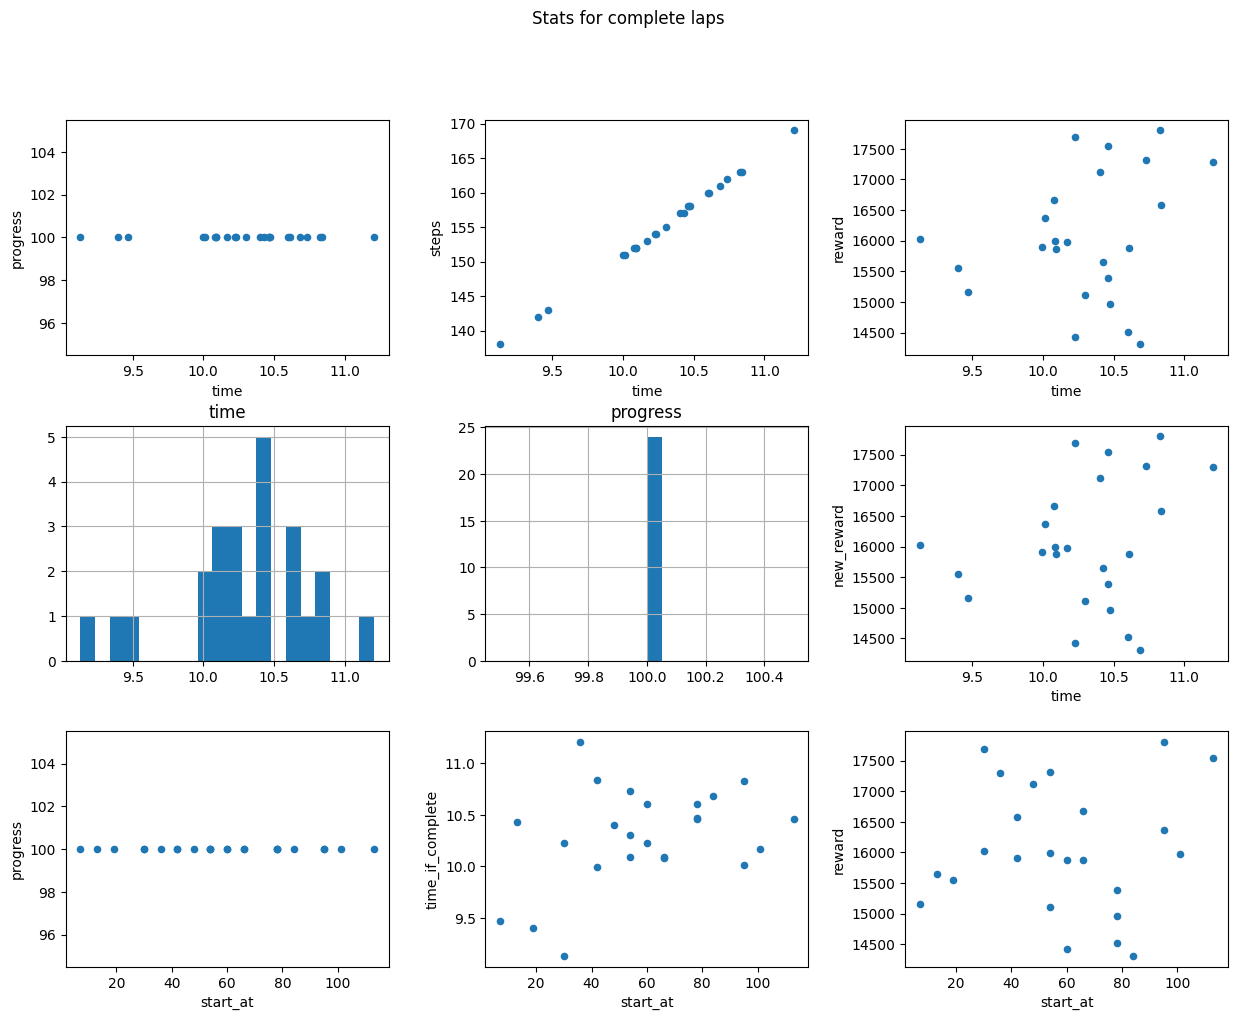

<Figure size 640x480 with 0 Axes>

In [202]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

### Categories analysis
品类分析
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
我们将回到基于训练时间的训练结果比较，但方式不同。这一次，我们不是仅仅根据迭代或剧集编号来分散内容，而是根据特定信息对剧集进行分组。为此，我们使用函数：
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.
这个想法非常简单：确定一种对数据进行聚类的方法，并将其作为“类别”参数提供（以及可用组的计数）。在默认情况下，我们利用剧集所属的五分位数的聚合信息，从而构建每个存储桶，每个存储桶包含训练期间大约在同一时间发生的 20% 的剧集。如果您的训练持续了五个小时，这将显示每小时分组的结果。

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.
旁注：如果您使用 'category='start_at'' 和 'groupcount=20' 运行函数，您将根据最接近剧集起点的航点获得结果。如果需要，可以引入其他类型的类别并重用该函数。

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.
这些图表与我们上面看到的类似。我特别喜欢进度，它显示了模型在哪些方面容易挣扎，以及成功圈速是提高还是开始下降。有趣的是，我也遇到过这样的情况，我看到进度率的完成率下降，只是在后来的五分位数中有所改善，但时间图更好。
A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.
第二个旁注：如果您为“complete_ones”而不是“simulation_agg”运行此函数，则时间直方图会突然变得更加有趣，因为您可以看到完成时间是否有所改善。

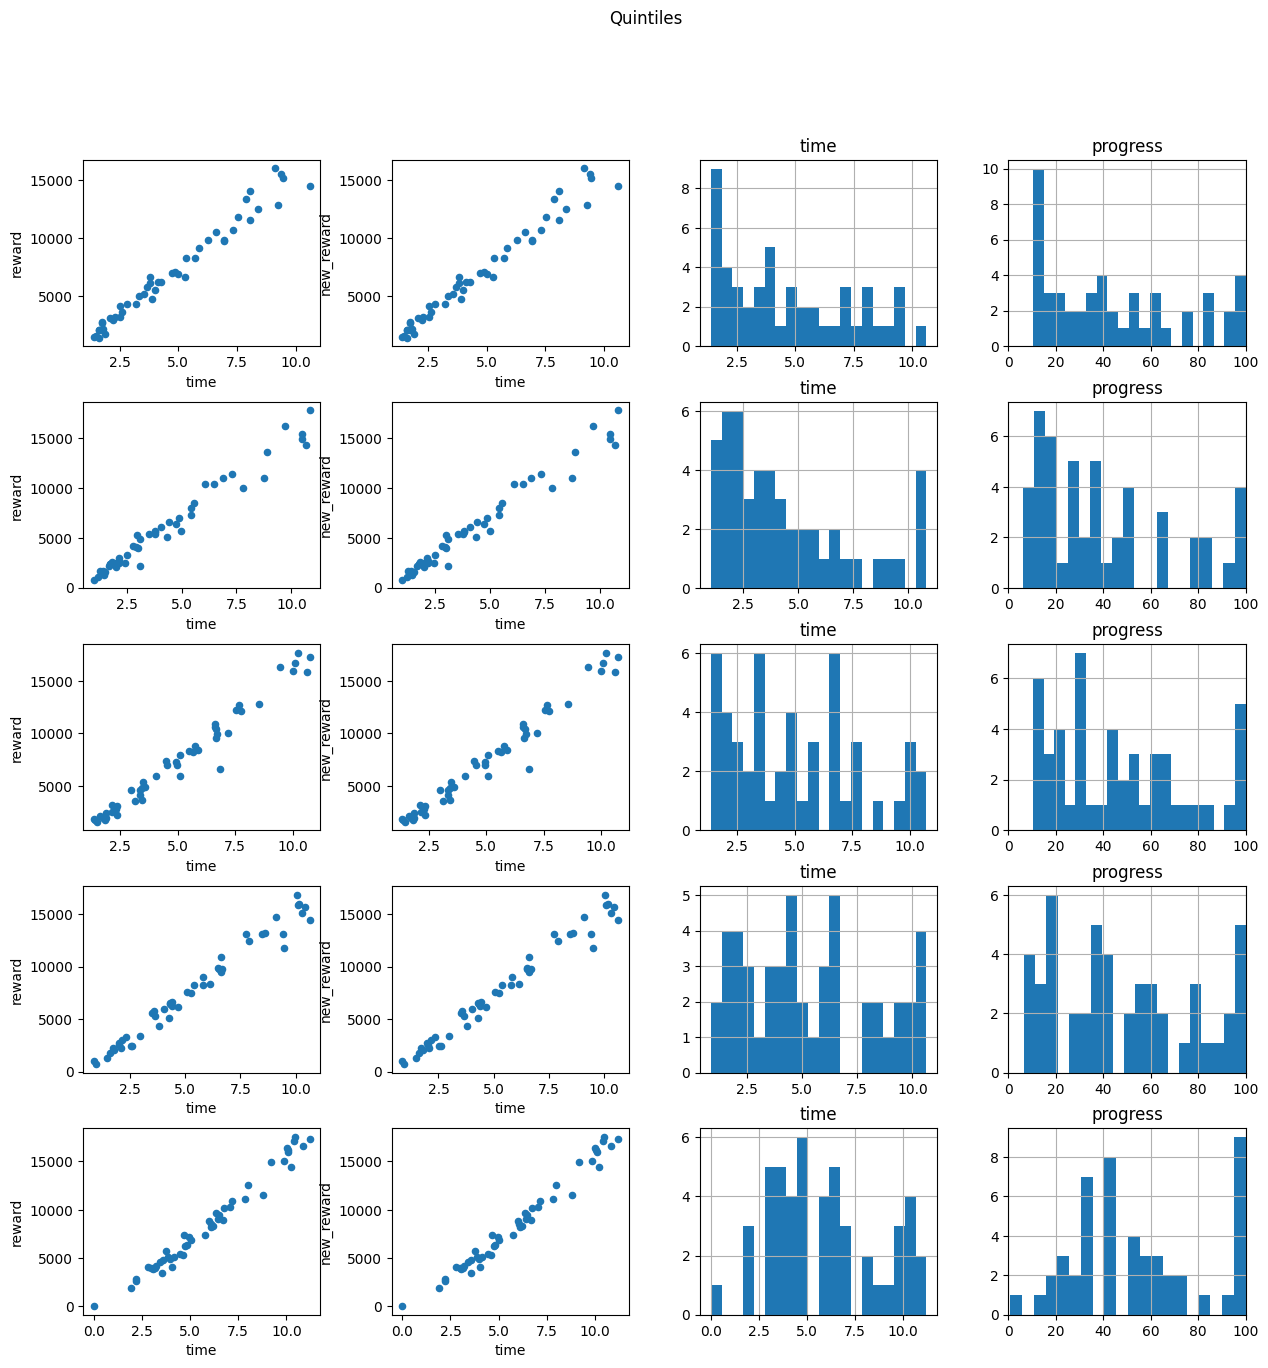

<Figure size 640x480 with 0 Axes>

In [203]:
au.scatter_by_groups(simulation_agg, title='Quintiles')


## Data in tables
表中的数据
While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.
虽然在图表中可以看到很多在原始数字中看不到的东西，但这些数字让我们更详细地了解。下面您将找到几个示例。如果您的模型按照您希望的方式运行，那幺下面的表格可能几乎没有附加值，但如果您努力提高汽车的性能，它们可能会派上用场。在这种情况下，我会寻找一些例子，其中高奖励给予低于预期的剧集，而当好剧集给予低奖励时。

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.
然后，您可以获取剧集编号并将其分散在下面，并查看每步给出的奖励，这反过来可以将您的注意力吸引到一些奖励异常上，并帮助您在奖励函数中检测一些意想不到的结果。

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe
有多种方法可以选择要显示的数据：
* 'nlargest'/'nsmallest' 允许您根据最高或最低的特定值显示信息
* 基于字段值的过滤，例如“df[df['episode']==10]”将仅显示“df”中属于第 10 集的那些步骤
* 'head（）' 让你窥视数据帧

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

这里没有一组合适的表格可以显示，下面的表格可能不适合你的需求。更多地了解熊猫，并与它们一起玩乐。它几乎和 DeepRacer 本身一样令人上瘾。

The examples have a short comment next to them explaining what they are showing.
这些示例旁边有一个简短的注释，解释了它们所显示的内容。

In [204]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
76,4,76,163,95,100.0000,10.827,18.438111,17800.0461,1.912270,17800.0461,10.827000,17800.046100,2nd,1
125,7,125,154,30,100.0000,10.230,17.613689,17691.5257,1.866234,17691.5257,10.230000,17691.525700,3rd,1
219,11,219,158,113,100.0000,10.464,18.023589,17545.4768,1.877215,17545.4768,10.464000,17545.476800,5th,1
129,7,129,162,54,100.0000,10.732,17.747132,17311.8348,1.785185,17311.8348,10.732000,17311.834800,3rd,1
226,12,226,169,36,100.0000,11.207,17.772257,17292.5945,1.688166,17292.5945,11.207000,17292.594500,5th,1
208,11,208,157,48,100.0000,10.402,17.576409,17113.7557,1.852229,17113.7557,10.402000,17113.755700,5th,1
147,8,147,152,42,96.2423,10.059,17.178337,16854.4771,1.893421,16854.4771,10.451745,17512.546043,4th,0
111,6,111,152,66,100.0000,10.080,17.035815,16669.7510,1.803289,16669.7510,10.080000,16669.751000,3rd,1
207,11,207,163,42,100.0000,10.839,17.354326,16574.6050,1.715337,16574.6050,10.839000,16574.605000,5th,1
216,11,216,151,95,100.0000,10.015,17.409798,16368.5132,1.898675,16368.5132,10.015000,16368.513200,5th,1


In [205]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
5,1,5,138,30,100.0,9.130,17.361893,16023.8231,2.087681,16023.8231,9.130,16023.8231,1st,1
3,1,3,142,19,100.0,9.398,17.076691,15557.9407,1.965493,15557.9407,9.398,15557.9407,1st,1
21,2,21,143,7,100.0,9.467,17.241075,15165.4650,2.074126,15165.4650,9.467,15165.4650,1st,1
127,7,127,151,42,100.0,9.996,17.485373,15903.5929,1.904636,15903.5929,9.996,15903.5929,3rd,1
216,11,216,151,95,100.0,10.015,17.409798,16368.5132,1.898675,16368.5132,10.015,16368.5132,5th,1


In [206]:
# View five best rewarded completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
76,4,76,163,95,100.0,10.827,18.438111,17800.0461,1.912270,17800.0461,10.827,17800.0461,2nd,1
125,7,125,154,30,100.0,10.230,17.613689,17691.5257,1.866234,17691.5257,10.230,17691.5257,3rd,1
219,11,219,158,113,100.0,10.464,18.023589,17545.4768,1.877215,17545.4768,10.464,17545.4768,5th,1
129,7,129,162,54,100.0,10.732,17.747132,17311.8348,1.785185,17311.8348,10.732,17311.8348,3rd,1
226,12,226,169,36,100.0,11.207,17.772257,17292.5945,1.688166,17292.5945,11.207,17292.5945,5th,1


In [207]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
76,4,76,163,95,100.0,10.827,18.438111,17800.0461,1.912270,17800.0461,10.827,17800.0461,2nd,1
125,7,125,154,30,100.0,10.230,17.613689,17691.5257,1.866234,17691.5257,10.230,17691.5257,3rd,1
219,11,219,158,113,100.0,10.464,18.023589,17545.4768,1.877215,17545.4768,10.464,17545.4768,5th,1
129,7,129,162,54,100.0,10.732,17.747132,17311.8348,1.785185,17311.8348,10.732,17311.8348,3rd,1
226,12,226,169,36,100.0,11.207,17.772257,17292.5945,1.688166,17292.5945,11.207,17292.5945,5th,1


In [208]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
3,1,3,142,19,100.0,9.398,17.076691,15557.9407,1.965493,15557.9407,9.398,15557.9407,1st,1
5,1,5,138,30,100.0,9.130,17.361893,16023.8231,2.087681,16023.8231,9.130,16023.8231,1st,1
21,2,21,143,7,100.0,9.467,17.241075,15165.4650,2.074126,15165.4650,9.467,15165.4650,1st,1
33,2,33,160,78,100.0,10.602,18.026816,14516.7067,1.851875,14516.7067,10.602,14516.7067,1st,1
53,3,53,158,78,100.0,10.462,18.122228,15392.3318,1.922152,15392.3318,10.462,15392.3318,2nd,1


In [209]:
# View information for a couple first episodes
# 查看前几集的信息
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,dist,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
0,1,0,56,1,33.0486,3.668,6.098569,5783.3345,2.067857,5783.3345,11.098806,17499.484093,1st,0
1,1,1,51,7,31.6265,3.330,5.608600,5063.2512,2.192157,5063.2512,10.529145,16009.521129,1st,0
2,1,2,39,13,22.9547,2.528,4.129346,4143.8164,2.328205,4143.8164,11.012995,18052.147926,1st,0
3,1,3,142,19,100.0000,9.398,17.076691,15557.9407,1.965493,15557.9407,9.398000,15557.940700,1st,1
4,1,4,25,25,13.0486,1.600,2.462782,2125.9080,2.020000,2125.9080,12.261852,16292.230584,1st,0


In [220]:
# Set maximum quantity of rows to view for a dataframe display - without that
# 设置要查看的数据帧显示的最大行数
# the view below will just hide some of the steps
# 下面的视图将隐藏一些步骤
pd.set_option('display.max_rows', 100)

# View all steps data for episode 10
df[df['episode']==21]

,iteration,episode,steps,x,y,yaw,steering_angle,speed,action,reward,...,on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,delta_time,delta_dist,new_reward
1576,2,21,1,4.0854,0.6837,0.0421,23.0,1.8,9,0.0000,...,True,0.7915,7,17.71,128.437,prepare,0.0,0.000,0.000000,0.0000
1577,2,21,2,4.0852,0.6836,0.0199,0.0,3.7,4,161.1061,...,True,0.7906,7,17.71,128.511,in_progress,0.0,0.074,0.000224,161.1061
1578,2,21,3,4.0961,0.6856,0.7265,0.0,3.7,4,147.1955,...,True,0.8520,7,17.71,128.57,in_progress,0.0,0.059,0.011082,147.1955
1579,2,21,4,4.1193,0.6860,0.7093,0.0,3.7,4,142.4145,...,True,0.9830,7,17.71,128.65,in_progress,0.0,0.080,0.023203,142.4145
1580,2,21,5,4.1629,0.6852,0.2830,0.0,3.7,4,142.4302,...,True,1.2293,7,17.71,128.713,in_progress,0.0,0.063,0.043607,142.4302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,2,21,139,3.2790,0.5480,-4.9648,0.0,3.7,4,166.9907,...,True,96.2370,1,17.71,137.646,in_progress,0.0,0.073,0.174100,166.9907
1715,2,21,140,3.4854,0.5378,-3.5655,-30.0,1.9,1,91.5964,...,True,97.4035,3,17.71,137.715,in_progress,0.0,0.069,0.206652,91.5964
1716,2,21,141,3.6675,0.5270,-3.2592,-30.0,1.9,1,91.7850,...,True,98.4316,4,17.71,137.777,in_progress,0.0,0.062,0.182420,91.7850
1717,2,21,142,3.8339,0.5111,-4.5133,23.0,1.8,9,90.5269,...,True,99.3714,5,17.71,137.843,in_progress,0.0,0.066,0.167158,90.5269


## Analyze the reward distribution for your reward function

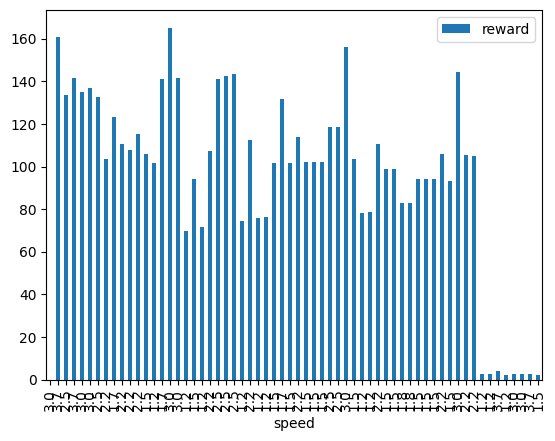

In [211]:
# This shows a histogram of actions per closest waypoint for episode 889.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']==140]

if episode.empty:
    print("You probably don't have episode with this number, try a lower one.")
else:
    episode.plot.bar(x='speed', y='reward')

### Path taken for top reward iterations
顶级奖励迭代所采用的路径
NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.
注意：在过去某个时间点，在一集中，汽车可以绕多圈，当汽车完成 1000 步时，该剧集就终止了。目前一集最多一圈。这就解释了为什幺您可以在下面绘制的一集中看到多圈。
Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.
能够在一集中绘制汽车的路线可以帮助您检测其行为中的某些模式，并进一步促进它们或远离它们。虽然能够在训练中观看汽车行驶会提供一些信息，但能够在训练后重现它更实用。
Graphs below give you a chance to look deeper into your car's behaviour on track.
下面的图表让您有机会更深入地了解您的汽车在赛道上的行为。
We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.
我们从plot_selected_laps开始。这个块的总体思路如下：
* 选择具有您关心的属性的圈数（剧集），例如，最快、进步最大、在赛道的某个部分失败或在那里没有失败，
* 在plot_selected_laps中提供数据帧中的列表，以及整个训练数据帧和跟踪信息，
* 你有圈数要分析。

Multiple workers not detected, assuming 1 worker


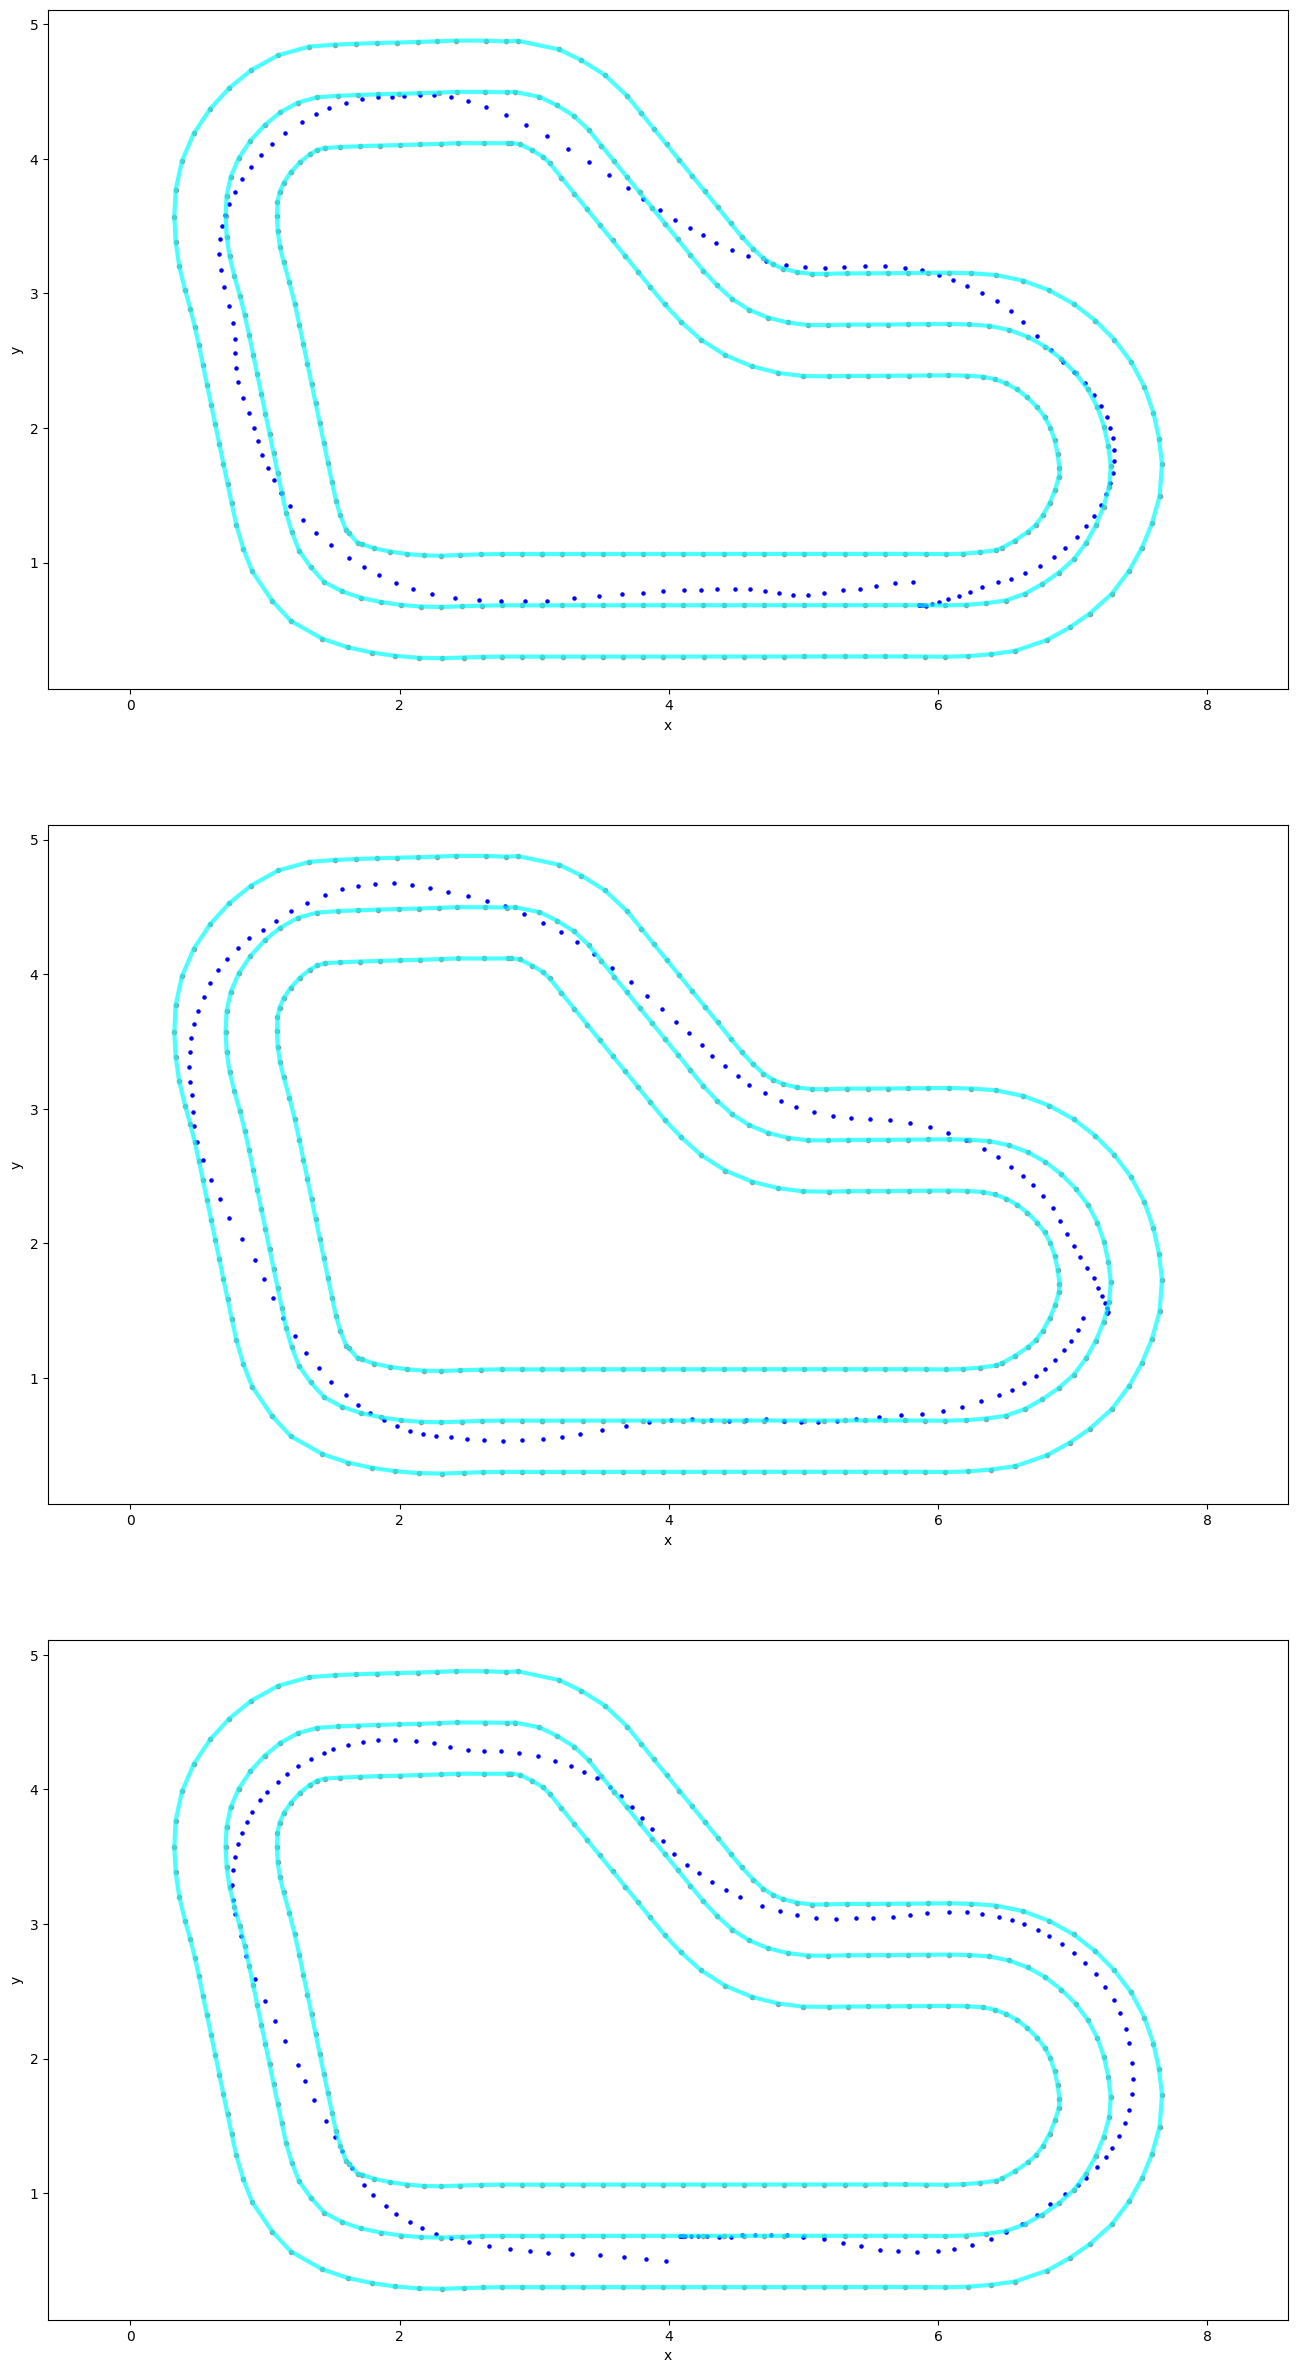

<Figure size 640x480 with 0 Axes>

In [212]:
# Some examples:
# highest reward for complete laps:
# episodes_to_plot = complete_ones.nlargest(3,'reward')

# highest progress from all episodes:
episodes_to_plot = simulation_agg.nlargest(3,'progress')

try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps(episodes_to_plot, df, track, section_to_plot="unique_episode")
    else:
        pu.plot_selected_laps(episodes_to_plot, df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps(episodes_to_plot, df, track)

### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

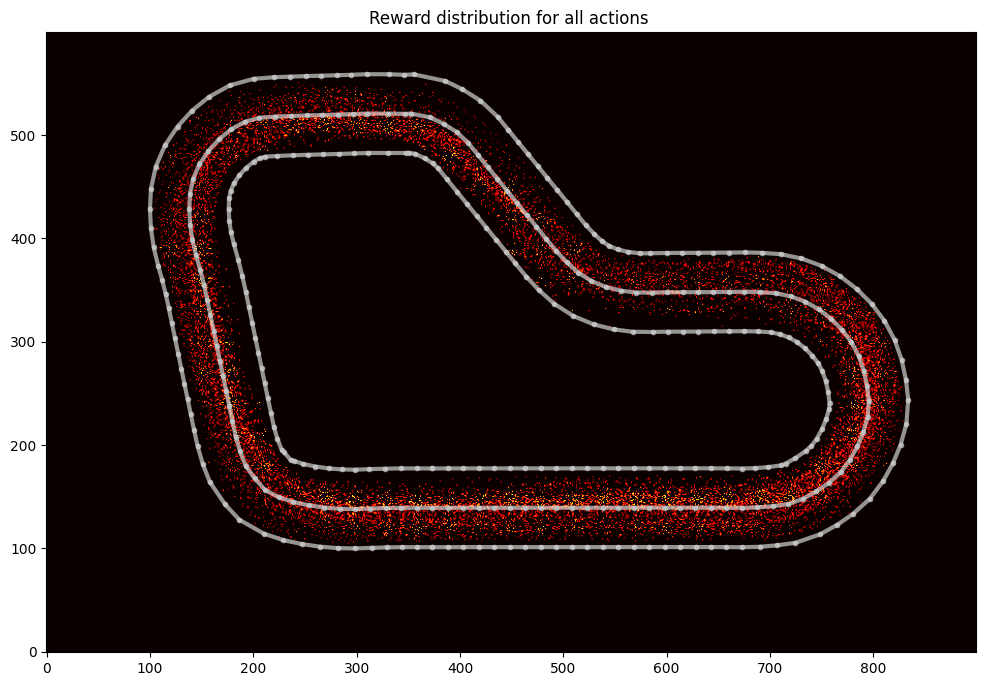

<Figure size 640x480 with 0 Axes>

In [213]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

pu.plot_track(df, track)

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

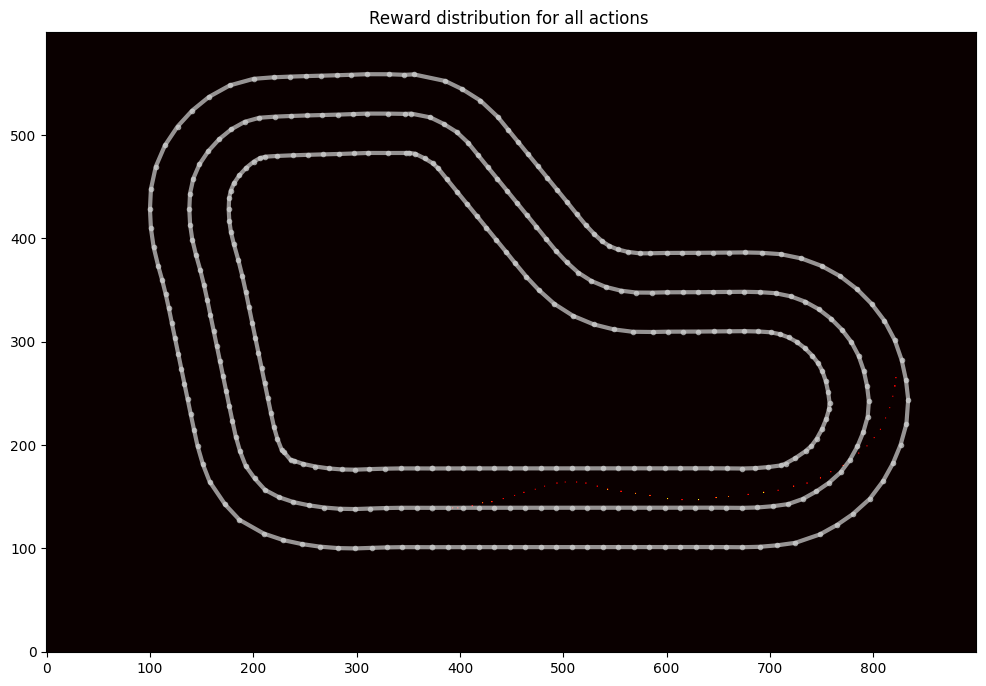

<Figure size 640x480 with 0 Axes>

In [214]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 1

# pu.plot_track(df[df['iteration'] == iteration_id], track)
pu.plot_track(df[df['episode'] == 40], track)

### Path taken in a particular episode

In [215]:
episode_id = 40

Multiple workers not detected, assuming 1 worker


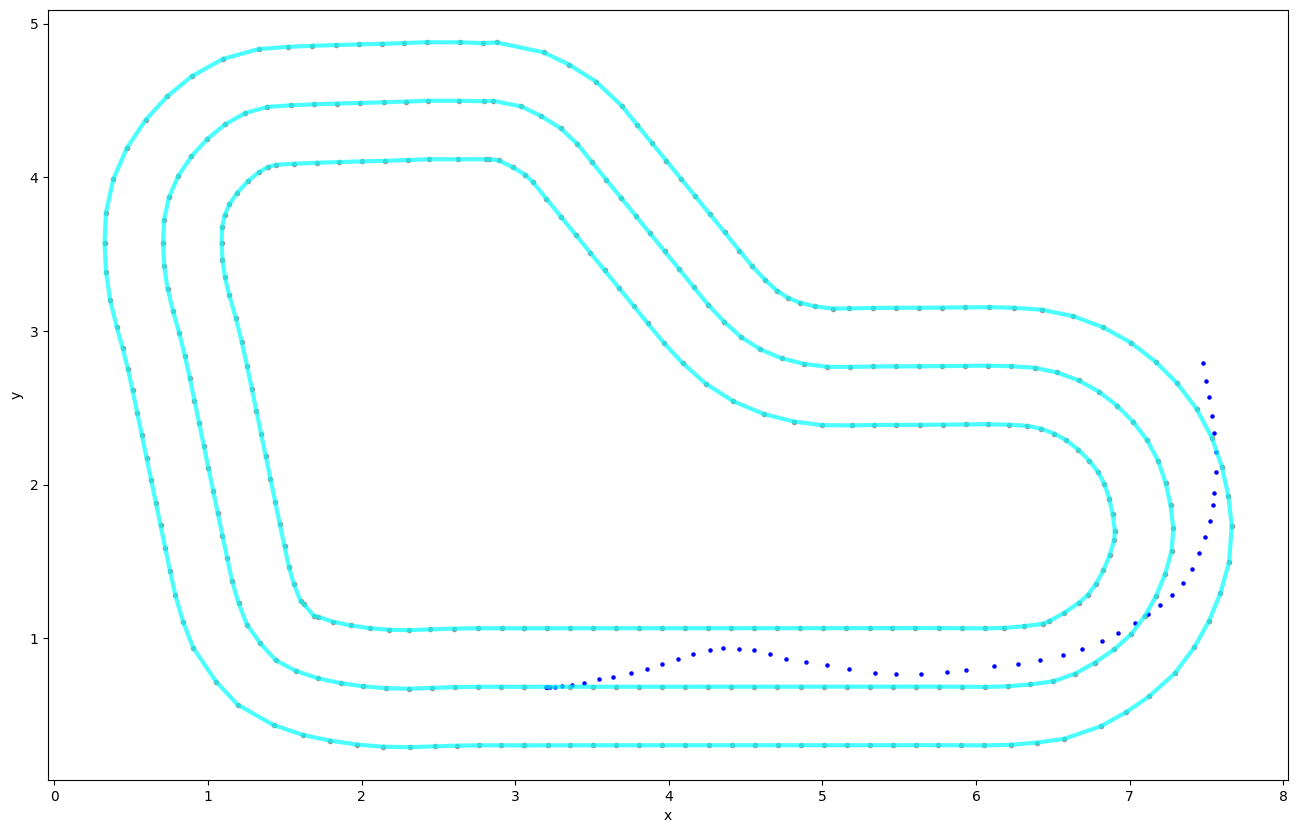

<Figure size 640x480 with 0 Axes>

In [216]:
try:
    if df.nunique(axis=0)['worker'] > 1:
        pu.plot_selected_laps([episode_id], df, track, section_to_plot="unique_episode")
    else: 
        pu.plot_selected_laps([episode_id], df, track)
except:
    print("Multiple workers not detected, assuming 1 worker")
    pu.plot_selected_laps([episode_id], df, track)

### Path taken in a particular iteration

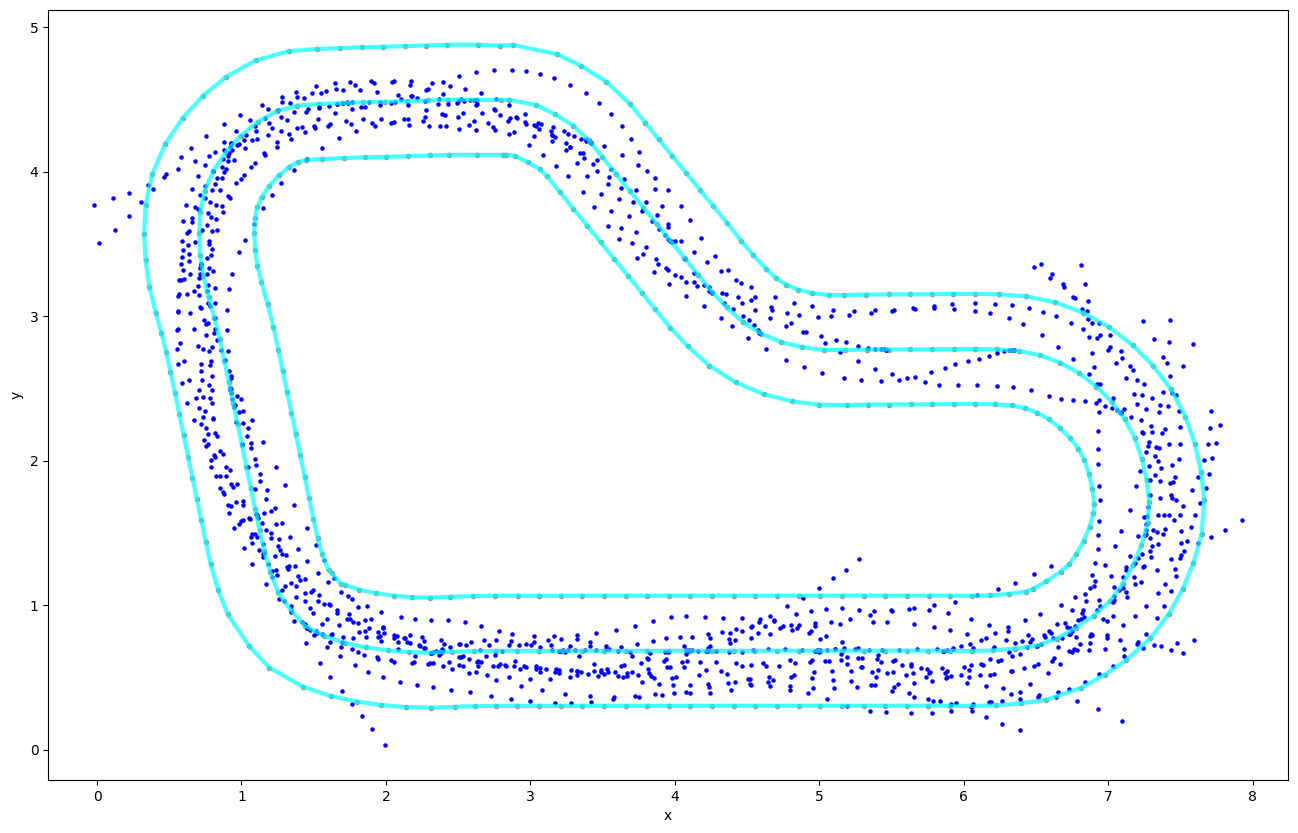

<Figure size 640x480 with 0 Axes>

In [217]:
iteration_id = 2

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track
每次迭代的动作分解和每个回合的动作分布的 historgram 重新发明轨道
This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.
此图有助于了解模型对任何给定迭代所采取的操作。不幸的是，目前它不适合目的，因为它在操作空间中假设了六个操作并且存在其他问题。完成它需要一些工作，但它返回的信息将非常有价值。
This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.
这有点尝试从原始笔记本中的出色功能抽象出来，转向我们可以使用的更通用的图形。它应被视为一项正在进行的工作。该track_breakdown可以用作常规跟踪信息对象的起点，以处理此笔记本方法中所需的所有自定义。
A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [218]:
track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

You can replace episode_ids with iteration_ids and make a breakdown for a whole iteration.
您可以将episode_ids替换为 iteration_ids，并对整个迭代进行细分。
**Note: does not work for continuous action space (yet).** 

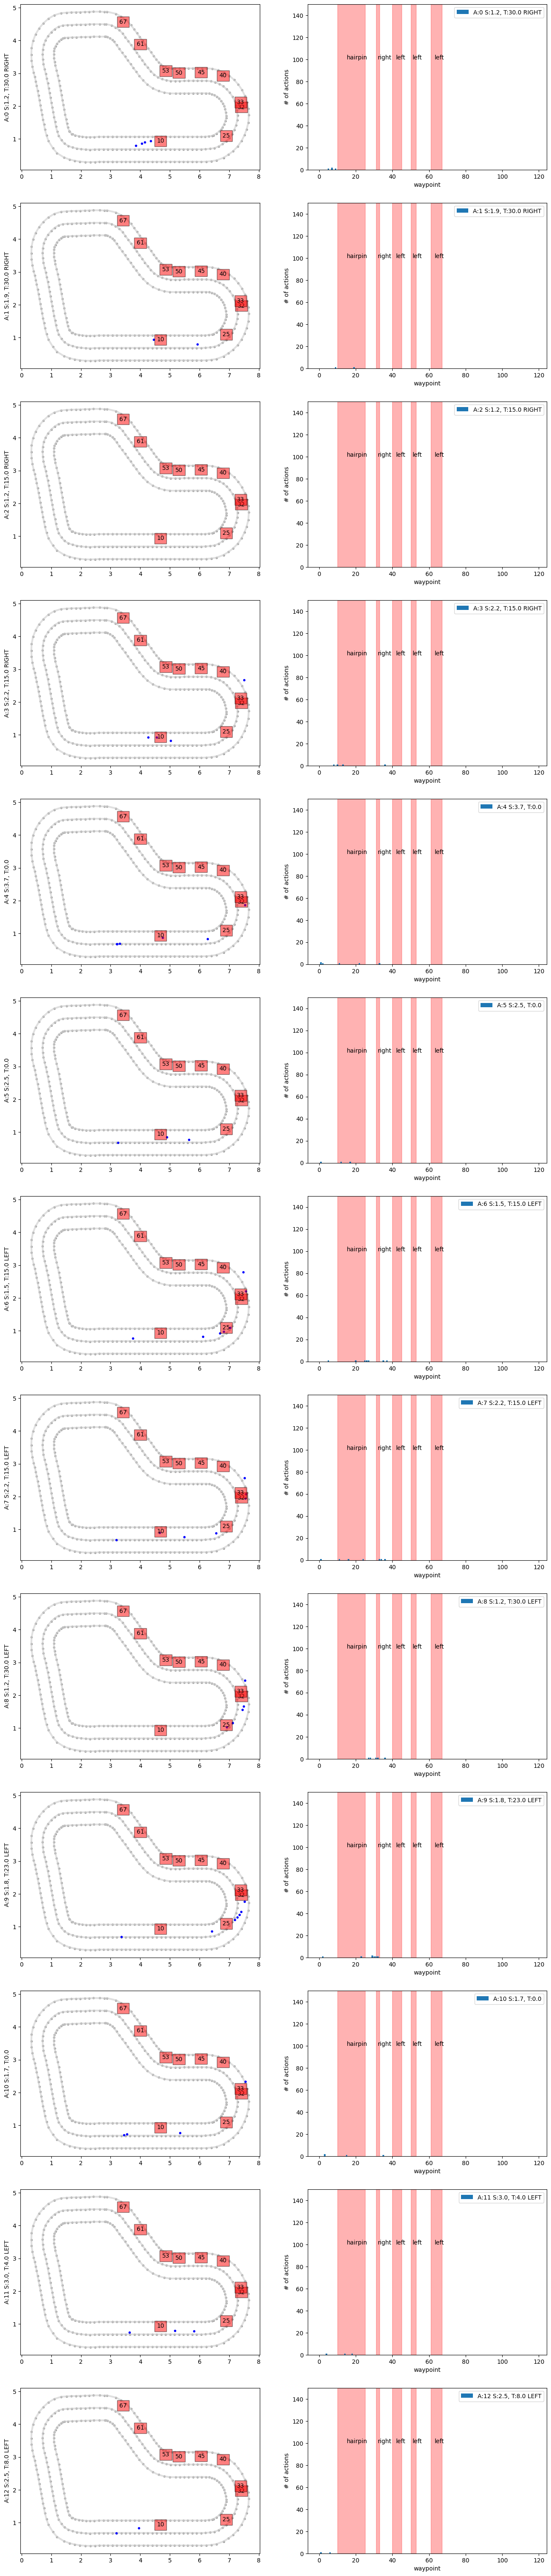

<Figure size 640x480 with 0 Axes>

In [219]:
abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[40])